# Plots for the 2MDM analysis

In [6]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import re,os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from scipy.interpolate import griddata,interp1d
from itertools import product
import pyslha

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu_r']

### Load Relic Density scan 

In [7]:
scanLabel = 'scan3'
scanSummary = os.path.join('../data/maddmOutput/',scanLabel,'output/scan_run_01.txt')
with open(scanSummary,'r') as f:
    headerLines = [l for l in f.readlines() if l.strip() and l.strip()[0] == '#']
columnLabels = {eval(re.sub(r'\b0', '',h.split(':')[0].replace('[','').replace(']','').replace('#',''))) : 
                     h.split(':')[1].replace('\n','').strip().replace('%','pc') for h in headerLines}
header = ['']*len(columnLabels)
for i,label in columnLabels.items():
    header[i-1] = label
relicData = pd.read_csv(scanSummary,names=header,
                        comment='#',delimiter='\t',index_col=False)
# Remove unused columns:
relicData.drop(columns=[c for c in relicData.columns if 'pc_relic' in c]+['Nevents','smearing','xsi','x_f','sigmav(xf)'],inplace=True)
# Rename columns:
renameDict = {'Omegah^2' : 'Omegah2', 'mass#9000006' : 'mChi', 'mass#9900032' : 'mZp', 'mass#9900026' : 'mS'}
relicData.rename(columns=renameDict,inplace=True)
print(relicData.columns)

Index(['run', 'mChi', 'mS', 'mZp', 'Omegah2', 'sigmaN_SI_p', 'lim_sigmaN_SI_p',
       'sigmaN_SI_n', 'lim_sigmaN_SI_n', 'sigmaN_SD_p', 'lim_sigmaN_SD_p',
       'sigmaN_SD_n', 'lim_sigmaN_SD_n'],
      dtype='object')


### Load LZ limits

In [8]:
LZ_curve = np.genfromtxt('../data/LZ_2207.03764_SI_limits.txt',names=True)
LZ_limitF = np.vectorize(interp1d(LZ_curve['mass'],LZ_curve['limit']))

### Analytical Expression for v-suppressed sigmaSI

In [9]:
fN = 0.3
mh = 125.0
Mn = 0.939
GF = 1.166e-5
v = 0.001 # From 1904.01017v2 -> below Eq.18
GeVm2Tocmm2 = 1/((5.06e13)**2)
pbTocmm2 = 1e-36
@np.vectorize
def sigmaz_gev(mChi,msd,mZp,sina,gB=None,gchi=None,gq=None):
    if gchi is None:
        gchi = -(3./2.)*gB # If gB is given, assume 2405.03749 conventions
    if gq is None:
        gq = (gB/3.0)# If gB is given, assume 2405.03749 conventions
    sv = (27/(2*np.pi))*gchi**2*gq**2*(Mn**2/mZp**4)*v**2
    return sv*GeVm2Tocmm2

### Get Model Parameters

In [10]:
modelPars = pyslha.readSLHAFile(os.path.join('../data/maddmOutput',scanLabel,'Cards/param_card.dat'))
gchi = modelPars.blocks['NPINPUTS'][1]
gq = modelPars.blocks['NPINPUTS'][2]
sina = modelPars.blocks['NPINPUTS'][3]
# mS = modelPars.blocks['MASS'][9900026]


textstr = '\n'.join((
    r'$m_S = (m_{Z^\prime} + m_{\chi})/2$',
    r'$g_q =$ %1.2f' %gq,
    r'$g_\chi =$ %1.2f' %gchi,
    r'$\sin\alpha =$ %1.1f' %sina))


### Compute r-values

In [11]:
# Compute r values:
relicData['r_omega'] = relicData['Omegah2']/0.12
dd_rescaling = (np.minimum(1.0,relicData['r_omega']))
relicData['r_SI_p'] = dd_rescaling*relicData['sigmaN_SI_p']/relicData['lim_sigmaN_SI_p']
relicData['r_SI_n'] = dd_rescaling*relicData['sigmaN_SI_n']/relicData['lim_sigmaN_SI_n']
relicData['r_SD_p'] = dd_rescaling*relicData['sigmaN_SD_p']/relicData['lim_sigmaN_SD_p']
relicData['r_SD_n'] = dd_rescaling*relicData['sigmaN_SD_n']/relicData['lim_sigmaN_SD_n']
relicData['r_SI_LZ'] = dd_rescaling*relicData['sigmaN_SI_p']/LZ_limitF(relicData['mChi'])

#### Add limits from v-suppressed sigmaN

In [12]:
relicData['sigmaN_SI_v'] = sigmaz_gev(relicData['mChi'],relicData['mS'],relicData['mZp'],sina=sina,gchi=gchi,gq=gq)
relicData['r_SIv_LZ'] = dd_rescaling*relicData['sigmaN_SI_v']/LZ_limitF(relicData['mChi'])

### Compute maximum r-value

In [13]:
rList = ['r_omega','r_SI_p','r_SD_p','r_SI_LZ','r_SIv_LZ']
# rList = ['r_omega','r_SIv_LZ']
relicData['r_dm'] = relicData[rList].values.max(1)

### Load ATLAS curve

In [14]:
atlasCurve1 = np.array(list(zip([112.70553064275038, 178.77428998505232, 268.16143497757844, 342.0029895366218, 423.61733931240656, 509.118086696562, 563.5276532137518, 617.9372197309417, 680.1195814648729, 726.7563527653214, 788.9387144992526, 847.2346786248131, 1053.2137518684603, 1173.6920777279522, 1282.5112107623318, 1402.9895366218236, 1573.9910313901344, 1752.7653213751867, 1915.9940209267563, 2129.745889387145],[4.267425320056899, 19.203413940256045, 46.941678520625885, 72.54623044096728, 108.81934566145091, 136.55761024182075, 155.7610241820768, 174.96443812233284, 181.3655761024182, 204.83641536273115, 226.17354196301562, 258.17923186344234, 358.4637268847795, 422.47510668563297, 477.95163584637265, 535.5618776671407, 612.375533428165, 695.5903271692745, 772.4039829302986, 872.6884779516357])))
atlasCurve2 = np.array(list(zip([897.7578475336322, 862.780269058296, 823.9162929745889, 804.4843049327354, 788.9387144992526, 785.0523168908819, 804.4843049327354, 855.0074738415545, 913.3034379671151, 963.8266068759342, 1014.3497757847533, 1080.4185351270553, 1134.8281016442452, 1189.2376681614348, 1247.5336322869955, 1321.3751868460388, 1418.5351270553065],[889.7581792318633, 840.6827880512091, 793.7411095305831, 766.0028449502133, 733.9971550497866, 706.2588904694167, 684.9217638691322, 676.3869132290184, 674.25320056899, 687.0554765291606, 701.9914651493598, 725.4623044096728, 748.9331436699857, 770.2702702702702, 798.00853485064, 832.1479374110952, 872.6884779516357])))

/tmp/ipykernel_51823/3316111303.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


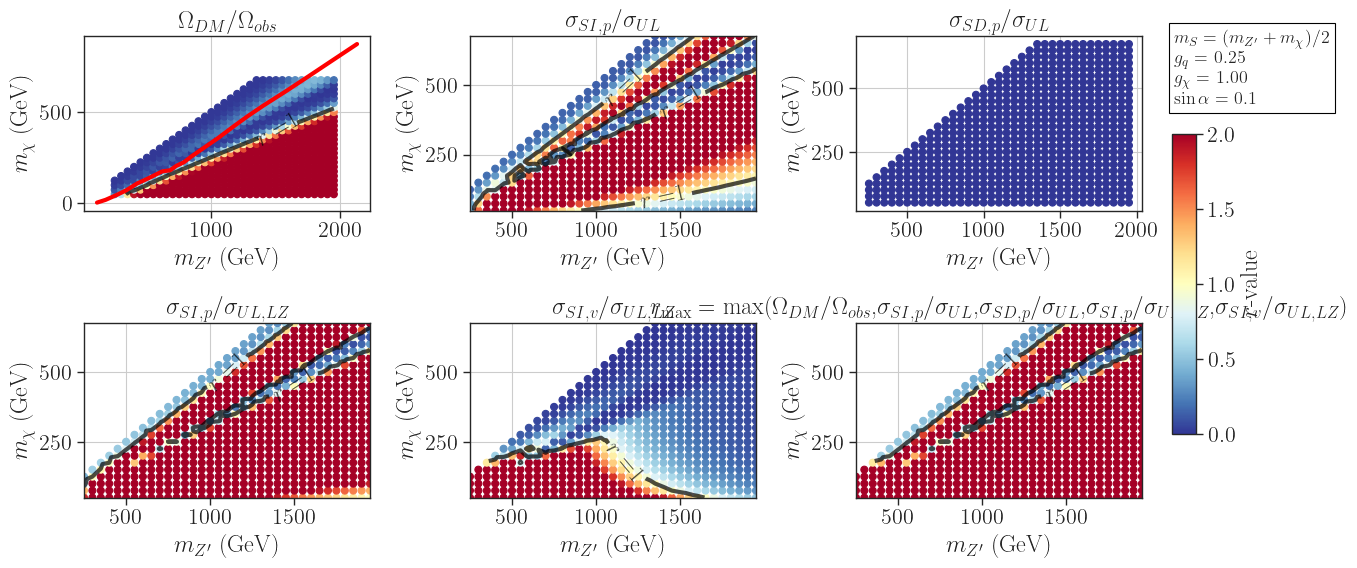

In [15]:
xLabels = {'mZp' : r'$m_{Z^\prime}$ (GeV)'}
yLabels = {'mChi' : r'$m_{\chi}$ (GeV)'}
zLabels = {'r_omega' : r'$\Omega_{DM}/\Omega_{obs}$',
           'r_SI_p' : r'$\sigma_{SI,p}/\sigma_{UL}$',
           'r_SD_p' : r'$\sigma_{SD,p}/\sigma_{UL}$',
           'r_SI_LZ' : r'$\sigma_{SI,p}/\sigma_{UL,LZ}$',
           'r_SIv_LZ' : r'$\sigma_{SI,v}/\sigma_{UL,LZ}$'
           }
zLabels['r_dm'] = r'$r_{\rm max}$ = max(%s)' %(','.join([zLabels[z] for z in rList]))

allPlots = list(product(xLabels.keys(),yLabels.keys(),zLabels.keys()))
nplots = len(allPlots)
ncols = 3
nrows =  (int(nplots/ncols))
if nrows*ncols < nplots: 
    nrows += 1

fig,axarr = plt.subplots(nrows=nrows,ncols=ncols,figsize=(4*ncols,3*nrows))
axarr = np.array(axarr).reshape(-1)

for iplot,(xLabel,yLabel,zLabel) in enumerate(allPlots):
    ax = axarr[iplot]

    p = ax.scatter(relicData[xLabel],relicData[yLabel],c=relicData[zLabel],s=25,
            cmap=cm, vmin=0.0,vmax=2.0)

    pts = np.array([y for y in product(np.unique(relicData[xLabel]),np.unique(relicData[yLabel]))])
    rPts = griddata(list(zip(relicData[xLabel],relicData[yLabel])),relicData[zLabel],pts)
    pts = pts[~np.isnan(rPts)]
    rPts = rPts[~np.isnan(rPts)]
    if (max(rPts) > 1.0 and min(rPts) < 1.0):
        cs = ax.tricontour(pts[:,0],pts[:,1], rPts, levels=[1.0], alpha=0.7,linewidths=3,colors='black')
        ax.clabel(cs, levels= [1.0], inline=True, fmt=r'$r = $%1.0f')
    if zLabel == 'r_omega':
        ax.plot(atlasCurve1[:,0],atlasCurve1[:,1],color='red',linewidth=3)
        # ax.plot(atlasCurve2[:,0],atlasCurve2[:,1],color='red',linewidth=3)
    
    
    ax.set_xlabel(xLabels[xLabel])
    ax.set_ylabel(yLabels[yLabel])
    ax.set_title(zLabels[zLabel])
    # ax.set_xlim(50.0,1.1*x.max())
    # ax.set_ylim(5.0,1.1*y.max())
    # ax.legend()
    ax.grid()

fig.subplots_adjust(right=0.92,top=1.1)
cbar_ax = fig.add_axes([0.99, 0.25, 0.02, 0.5]) 
fig.colorbar(p,label=r'$r$-value',cax=cbar_ax)

plt.text(0.1,1.1,textstr,fontsize=13,bbox=dict(facecolor='white', edgecolor='black'),
            transform = plt.gca().transAxes)
plt.tight_layout()
plt.show()    